# **Motorbike Ambulance Calls**
>Motorbike accidents and corresponded ambulance calls are highly depended on environmental and seasonal settings, like weather conditions, precipitation, day of week, season, hour of the day, etc. The data was aggregated over the course of two years, on hourly basis, and then extracted and extended with the corresponding weather and seasonal information.


## **Associated tasks**

---


**Regression**

Prediction of the hourly ambulance calls count based on the environmental and seasonal settings. Prediction model should provide monotonic in the terms of some features, if it is proved by data.

**Event and Anomaly Detection**

Define the  ambulance calls patterns with respect of special events and define the cases that might be considered as abnormal behavior.  

**Deliverables**

Full Texts Report that contains detail description of Data Analysis, Data Modelling and Patterns/Anomaly detection processes with conclusions and their explanations.
What is important here:
* See the **way you’re thinking** – what actions you’re implementing and why
* How **you code** and wrangle the data
* **Storytelling** capabilities – so we’re looking for the full-text structured report separately from the code/notebook
* **Suggestions** on the further  analytics/approaches which could be applied

## **Dataset characteristics:**

---



motorbike_ambulance_calls.csv has the following fields:

              - index: record index
              - date : date
              - season : season (1:springer, 2:summer, 3:fall, 4:winter)
              - yr : year (0: 2011, 1:2012)
              - mnth : month ( 1 to 12)
              - hr : hour (0 to 23)
              - holiday : whether day is holiday or not
              - weekday : day of the week
              - workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
              -  weathersit :
                      - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
                      - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
                      - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
                      - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
              - temp : Normalized temperature in Celsius. The values are divided to 41 (max)
              - atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
              - hum: Normalized humidity. The values are divided to 100 (max)
              - windspeed: Normalized wind speed. The values are divided to 67 (max)
              - cnt: count of total ambulance calls


In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt


In [18]:
dataset = pd.read_csv('motorbike_ambulance_calls.csv')

dataset['date'] = pd.to_datetime(dataset['date'], errors='coerce')
dataset['day_of_week'] = dataset['date'].dt.dayofweek
dataset['month'] = dataset['date'].dt.month
dataset['year'] = dataset['date'].dt.year

print(f"Dataset contains {dataset.shape[0]} rows and {dataset.shape[1]} columns.")


Dataset contains 17379 rows and 18 columns.


C:\Users\User\AppData\Local\Temp\ipykernel_21352\1689488587.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset['date'] = pd.to_datetime(dataset['date'], errors='coerce')


In [19]:
dataset_2011 = dataset[dataset['year'] == 2011]
dataset_2012 = dataset[dataset['year'] == 2012]

print(f"Records in 2011: {dataset_2011.shape[0]}")
print(f"Records in 2012: {dataset_2012.shape[0]}")


Records in 2011: 8645
Records in 2012: 8734


Використаєм квартилі щоб прибрати явні аномалії

In [21]:
def filter_by_quartiles(data, features):
    Q1 = data[features].quantile(0.25)
    Q3 = data[features].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    filtered_data = data[~((data[features] < lower_bound) | (data[features] > upper_bound)).any(axis=1)]
    return filtered_data

features_to_filter = ['temp', 'hum', 'windspeed', 'cnt']
filtered_2011 = filter_by_quartiles(dataset_2011, features_to_filter)
filtered_2012 = filter_by_quartiles(dataset_2012, features_to_filter)

print(f"Records after filtering 2011: {filtered_2011.shape[0]}")
print(f"Records after filtering 2012: {filtered_2012.shape[0]}")


Records after filtering 2011: 8358
Records after filtering 2012: 8397


Виявлення аномалій з допомогою Isolation Forest

In [22]:
def detect_anomalies(data, features, contamination=0.05):
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    iso_forest.fit(data[features])
    
    data['anomaly'] = iso_forest.predict(data[features])
    return data

anomalies_2011 = detect_anomalies(filtered_2011, features_to_filter)
anomalies_2012 = detect_anomalies(filtered_2012, features_to_filter)

print(f"Anomalies detected in 2011: {anomalies_2011[anomalies_2011['anomaly'] == -1].shape[0]}")
print(f"Anomalies detected in 2012: {anomalies_2012[anomalies_2012['anomaly'] == -1].shape[0]}")


Anomalies detected in 2011: 418
Anomalies detected in 2012: 420


C:\Users\User\AppData\Local\Temp\ipykernel_21352\1512360586.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['anomaly'] = iso_forest.predict(data[features])
C:\Users\User\AppData\Local\Temp\ipykernel_21352\1512360586.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['anomaly'] = iso_forest.predict(data[features])


In [23]:
anomalies_2011[anomalies_2011['anomaly'] == -1].to_csv('anomalies_2011.csv', index=False)
anomalies_2012[anomalies_2012['anomaly'] == -1].to_csv('anomalies_2012.csv', index=False)

print("Anomalies saved to 'anomalies_2011.csv' and 'anomalies_2012.csv'.")


Anomalies saved to 'anomalies_2011.csv' and 'anomalies_2012.csv'.


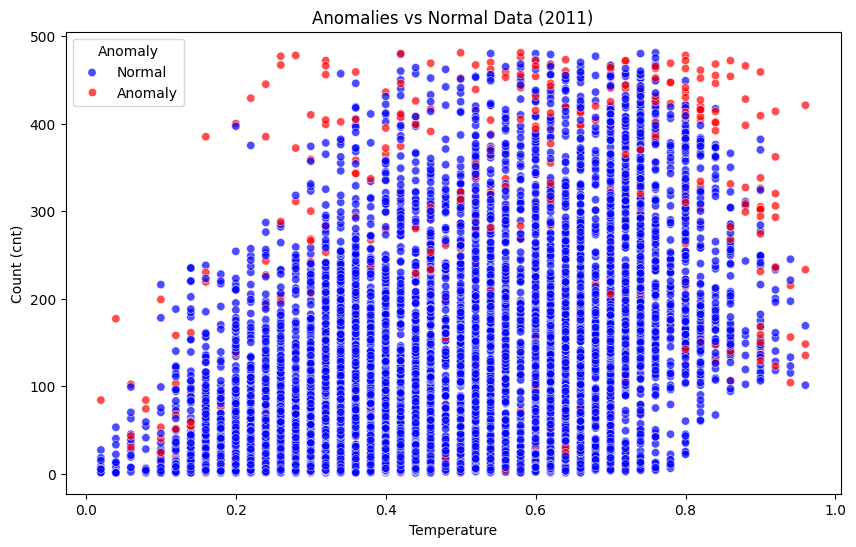

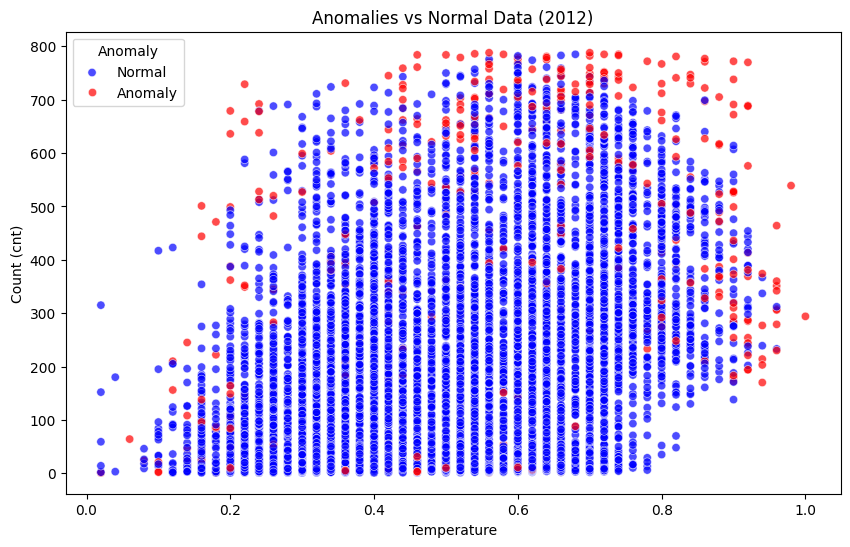

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temp', y='cnt', hue='anomaly', data=anomalies_2011, palette={1: 'blue', -1: 'red'}, alpha=0.7)
plt.title('Anomalies vs Normal Data (2011)')
plt.xlabel('Temperature')
plt.ylabel('Count (cnt)')
plt.legend(title='Anomaly', loc='upper left', labels=['Normal', 'Anomaly'])
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='temp', y='cnt', hue='anomaly', data=anomalies_2012, palette={1: 'blue', -1: 'red'}, alpha=0.7)
plt.title('Anomalies vs Normal Data (2012)')
plt.xlabel('Temperature')
plt.ylabel('Count (cnt)')
plt.legend(title='Anomaly', loc='upper left', labels=['Normal', 'Anomaly'])
plt.show()


Висновки: знайдено 838 аномалій. Спочатку ми розділили дата сет по роках адже дані різних років можуть бути аномальними на фоні один одного. Також використали квартильний метод щоб видалити викиди та підвищити точність моделі. У кінці ми використали Isolation Forest щоб знайти аномалії тазберегли їх у окремому датасеті